In [46]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

In [47]:
# --- Configuration ---
LOGS_DIR = "../logs/maze"  # folder containing CSVs from eval_maze.py
CSV_PATTERN = "*_metrics.csv"  # updated to match your CSVs
MONITOR_PATTERN = "*_monitor.csv"

In [48]:
# --- Load evaluation CSVs ---
def load_eval_csvs(eval_dir=LOGS_DIR, pattern=CSV_PATTERN):
    import glob, os, pandas as pd
    csv_files = glob.glob(os.path.join(eval_dir, pattern))
    dfs = []
    for f in csv_files:
        df = pd.read_csv(f)
        # Extract algo and persona from filename: e.g., "ppo_survivor_metrics.csv"
        fname = os.path.basename(f).replace("_metrics.csv", "")
        parts = fname.split("_")
        algo = parts[0]
        persona = parts[1] if len(parts) > 1 else "unknown"
        df['algo'] = algo
        df['persona'] = persona
        df['file'] = fname
        dfs.append(df)
    if len(dfs) == 0:
        raise ValueError(f"No evaluation CSVs found in {eval_dir} matching {pattern}")
    return pd.concat(dfs, ignore_index=True)

eval_df = load_eval_csvs()
print(f"Loaded {len(eval_df)} episodes across {eval_df['file'].nunique()} runs")
eval_df.head()

Loaded 200 episodes across 4 runs


,episode,reward,steps,coverage,algo,persona,file
0,1,0.2,50,2,a2c,explorer,a2c_explorer
1,2,0.2,50,2,a2c,explorer,a2c_explorer
2,3,0.3,50,3,a2c,explorer,a2c_explorer
3,4,0.4,50,4,a2c,explorer,a2c_explorer
4,5,0.2,50,2,a2c,explorer,a2c_explorer


In [49]:
def load_monitor_csvs(log_dir=LOGS_DIR):
    csv_files = glob.glob(os.path.join(log_dir, "*_monitor.csv"))
    if not csv_files:
        raise ValueError(f"No monitor CSV files found in {log_dir} matching *_monitor.csv")

    dfs = []
    for f in csv_files:
        # Extract algo and persona from filename: e.g. ppo_survivor_monitor.csv
        name = os.path.basename(f).replace("_monitor.csv","")
        parts = name.split("_")
        algo = parts[0]
        persona = parts[1] if len(parts) > 1 else "unknown"

        # Read monitor CSV (skip header comment line)
        df = pd.read_csv(f, comment="#", names=["reward","length","time"])
        df["reward"] = pd.to_numeric(df["reward"], errors="coerce")
        df["length"] = pd.to_numeric(df["length"], errors="coerce")
        df["time"] = pd.to_numeric(df["time"], errors="coerce")
        df = df.dropna(subset=["reward","length","time"])

        df["algo"] = algo
        df["persona"] = persona
        df["cum_timesteps"] = df["length"].cumsum()
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

monitor_df = load_monitor_csvs()
print(f"Loaded {len(monitor_df)} episodes from {monitor_df['algo'].nunique()} algorithms and {monitor_df['persona'].nunique()} personas.")


Loaded 23169 episodes from 2 algorithms and 2 personas.


In [50]:
# --- Summary statistics ---
summary = eval_df.groupby(['algo','persona']).agg({
    'reward': ['mean','std','min','max'],
    'steps': ['mean','std','min','max'],
    'coverage': ['mean','std','min','max']
}).reset_index()
summary

algo   persona  reward                       steps                     \
                    mean       std  min   max   mean        std min max   
0  a2c  explorer  0.2920  0.150970  0.0  0.70  50.00   0.000000  50  50   
1  a2c  survivor -0.2160  0.573767 -0.5  0.92  41.60  16.970563   8  50   
2  ppo  explorer  0.2640  0.148131  0.0  0.60  50.00   0.000000  50  50   
3  ppo  survivor -0.2728  0.525866 -0.5  0.92  43.28  15.553778   8  50   

  coverage                    
      mean       std min max  
0     3.02  1.362621   1   7  
1     3.90  2.517287   1   8  
2     2.80  1.277753   1   6  
3     3.30  2.305716   1   8

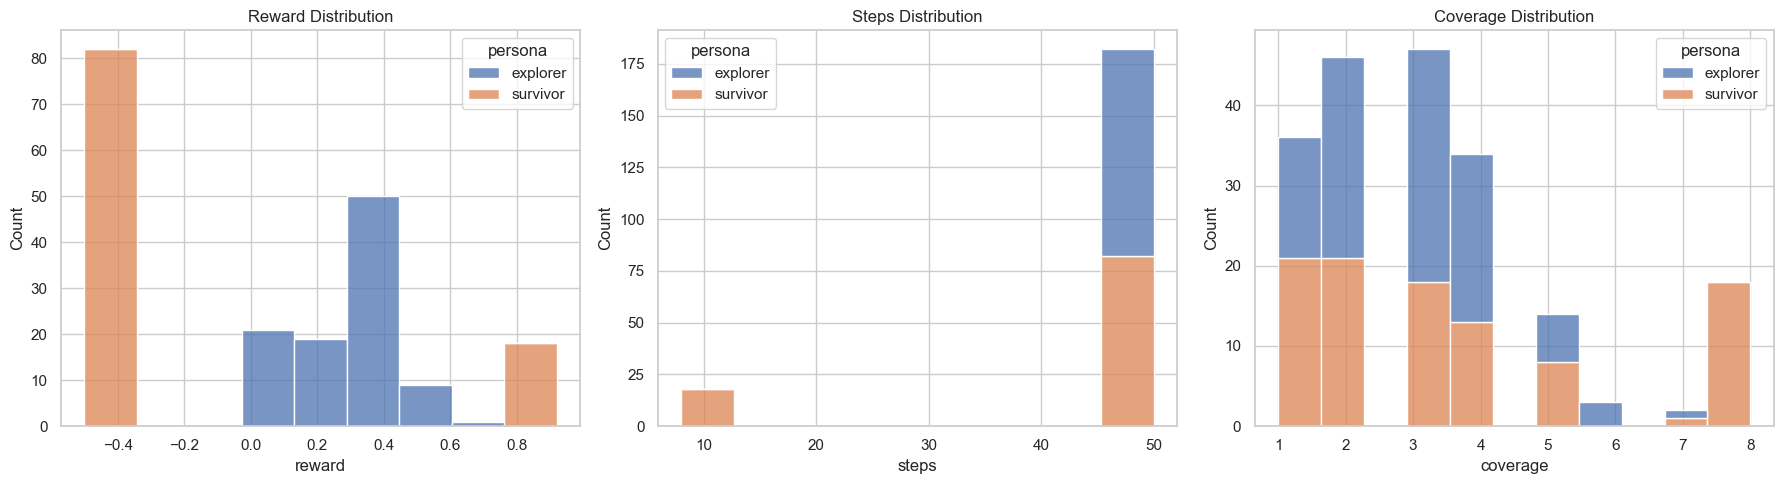

In [51]:
# --- Histograms / Distributions ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1,3,figsize=(18,5))

sns.histplot(eval_df, x="reward", hue="persona", multiple="stack", ax=axes[0])
axes[0].set_title("Reward Distribution")

sns.histplot(eval_df, x="steps", hue="persona", multiple="stack", ax=axes[1])
axes[1].set_title("Steps Distribution")

sns.histplot(eval_df, x="coverage", hue="persona", multiple="stack", ax=axes[2])
axes[2].set_title("Coverage Distribution")

plt.tight_layout()
plt.show()

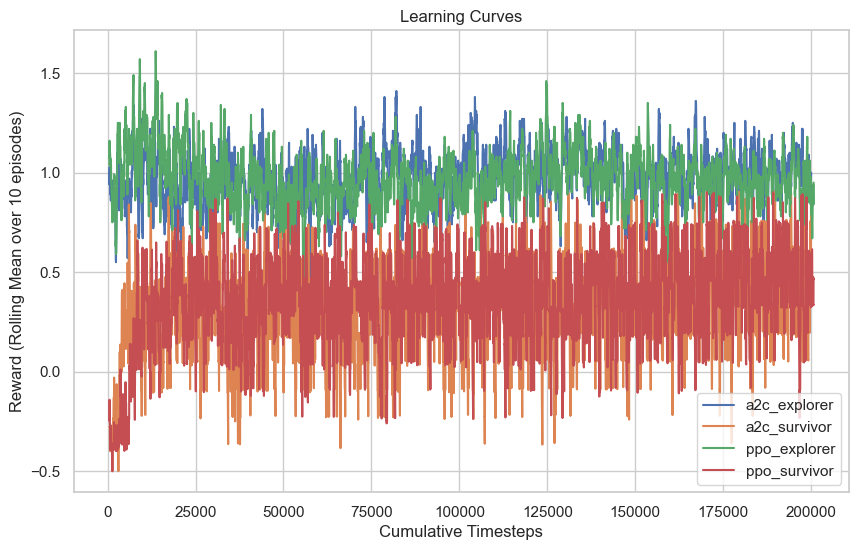

In [52]:
# ---------------- Learning Curves ----------------
plt.figure(figsize=(10,6))
for (algo, persona), group in monitor_df.groupby(['algo','persona']):
    plt.plot(group['cum_timesteps'], group['reward'].rolling(10).mean(), label=f"{algo}_{persona}")
plt.xlabel("Cumulative Timesteps")
plt.ylabel("Reward (Rolling Mean over 10 episodes)")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

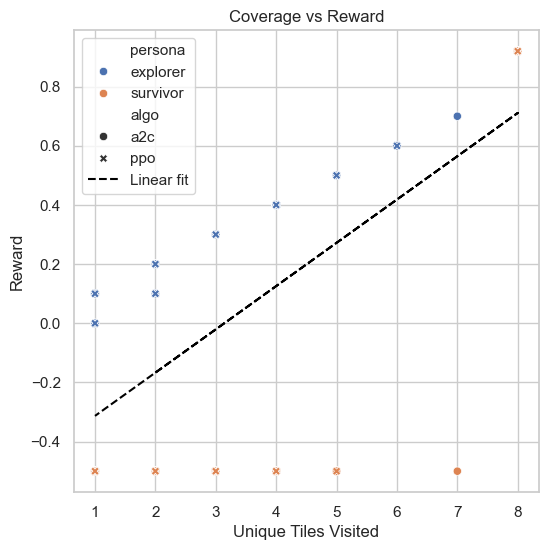

In [53]:
# --- Coverage vs Reward scatter + regression ---
plt.figure(figsize=(6,6))
sns.scatterplot(eval_df, x="coverage", y="reward", hue="persona", style="algo")
plt.title("Coverage vs Reward")
plt.xlabel("Unique Tiles Visited")
plt.ylabel("Reward")

# Fit regression line
X = eval_df["coverage"].values.reshape(-1,1)
y = eval_df["reward"].values
reg = LinearRegression().fit(X, y)
plt.plot(eval_df["coverage"], reg.predict(X), color='black', linestyle='--', label="Linear fit")
plt.legend()
plt.show()

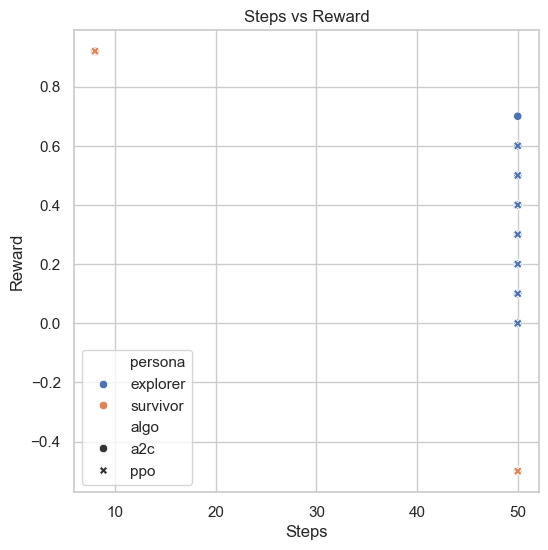

In [54]:
# --- Steps vs Reward scatter ---
plt.figure(figsize=(6,6))
sns.scatterplot(eval_df, x="steps", y="reward", hue="persona", style="algo")
plt.title("Steps vs Reward")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()